In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import matplotlib.pyplot as plt

from importlib import reload

import models
import plotting
import utils.dataloaders as dl
import traintest as tt
import adversarial as adv

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


In [2]:
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

In [3]:
class LeNetMadry(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 32, 5, 1, padding=2)
        self.conv2 = nn.Conv2d(32, 64, 5, 1, padding=2)
        self.fc1 = nn.Linear(7*7*64, 1024)
        self.fc2 = nn.Linear(1024, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2, 2)
        x = x.view(-1, 7*7*64)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        x = F.log_softmax(x, dim=1)
        return x

base_model = torch.load('SavedModels/madry.pth').to(device)

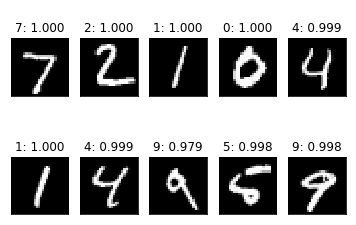

In [4]:
data, label = enumerate(dl.MNIST_test_loader).__next__()[1]

y_base = base_model(data.to(device))

plotting.plot_samples([y_base], data.detach().cpu())

In [6]:
loss_model = models.LossModel()
with torch.no_grad():
    loss_model.conv1.weight.data = torch.clone(base_model.conv1.weight)
    loss_model.conv1.bias.data = torch.clone(base_model.conv1.bias)
    
new_data = []
for i ,(data, label) in enumerate(dl.MNIST_train_loader):
    new_data.append(loss_model(data.to(device)).detach().cpu())
new_data = torch.cat(new_data, 0)

pca = models.PCAMetric(new_data.detach().cpu(), p=2, min_sv_factor=500.)

metric = models.PerceptualPCA(loss_model, pca)

In [11]:
gmm = models.GMM(1000, 784)
gmm.find_solution(dl.X_MNIST, initialize=True, iterate=False, use_kmeans=False)
#gmm_model = models.RobustModel(base_model, gmm, -7.).to(device)
gmm_model = models.RobustModel(base_model, gmm, -7.).to(device)
torch.save(gmm_model, 'SavedModels/GMM_Madry.pth')

/usr/local/lib/python3.5/dist-packages/torch/serialization.py:251: UserWarning: Couldn't retrieve source code for container of type LeNetMadry. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


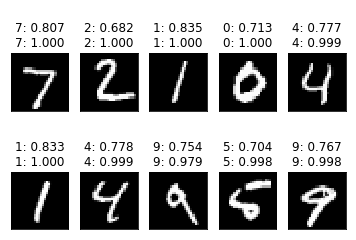

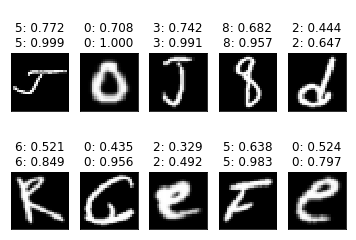

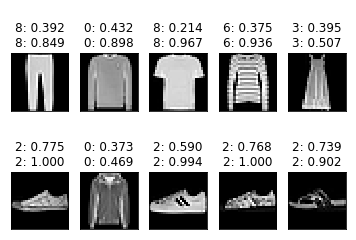




Test set: Average loss: 0.3262, Accuracy: 9740/10000 (97%), Ave. Confidence: 74%


Test set: Average loss: 0.0472, Accuracy: 9822/10000 (98%), Ave. Confidence: 98%


Ave. Confidence: 56% Predicted: 66%


Ave. Confidence: 84% Predicted: 93%



0.8386559893305485

In [10]:
#gmm_model.loglam.data = torch.tensor(-8., device=device)

data = enumerate(dl.MNIST_test_loader).__next__()[1][0]
y = gmm_model(data.to(device))
y_base = base_model(data.to(device))

plotting.plot_samples([y, y_base], data)

data = enumerate(dl.EMNIST_test_loader).__next__()[1][0]
y = gmm_model(data.to(device))
y_base = base_model(data.to(device))

plotting.plot_samples([y, y_base], data)

data = enumerate(dl.FMNIST_train_loader).__next__()[1][0]
y = gmm_model(data.to(device))
y_base = base_model(data.to(device))

plotting.plot_samples([y, y_base], data)

min_conf = .5
tt.test(gmm_model, device, dl.MNIST_test_loader, min_conf=min_conf)
tt.test(base_model, device, dl.MNIST_test_loader, min_conf=min_conf)

tt.test_adv(gmm_model, device, dl.EMNIST_test_loader, min_conf=min_conf)
tt.test_adv(base_model, device, dl.EMNIST_test_loader, min_conf=min_conf)

In [18]:
lr = .01
momentum = .9

optimizer_base = optim.SGD(gmm_model.mm.parameters(), lr=lr, momentum=momentum)
for epoch in range(2):
    optimizer_base.param_groups[0]['lr'] /= 1.1
    tt.train(gmm_model, device, dl.MNIST_train_loader, optimizer_base, epoch)

Train Epoch: 0 [0/60000 (0%)]	Loss: 0.038735
Train Epoch: 0 [10000/60000 (17%)]	Loss: 0.087620
Train Epoch: 0 [20000/60000 (33%)]	Loss: 0.016089
Train Epoch: 0 [30000/60000 (50%)]	Loss: 0.016524
Train Epoch: 0 [40000/60000 (67%)]	Loss: 0.016542
Train Epoch: 0 [50000/60000 (83%)]	Loss: 0.036126
Train Epoch: 1 [0/60000 (0%)]	Loss: 0.049111
Train Epoch: 1 [10000/60000 (17%)]	Loss: 0.032973
Train Epoch: 1 [20000/60000 (33%)]	Loss: 0.012181
Train Epoch: 1 [30000/60000 (50%)]	Loss: 0.028987
Train Epoch: 1 [40000/60000 (67%)]	Loss: 0.045464
Train Epoch: 1 [50000/60000 (83%)]	Loss: 0.021538


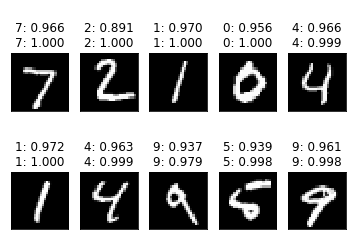

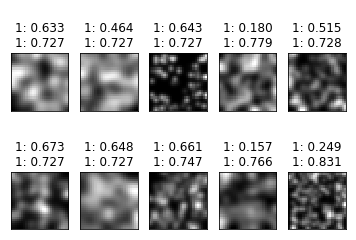




Test set: Average loss: 0.0894, Accuracy: 9819/10000 (98%), Ave. Confidence: 94%


Ave. Confidence: 73% Predicted: 84%



0.7316479836060451

In [40]:
data = enumerate(dl.MNIST_test_loader).__next__()[1][0]
y = gmm_model(data.to(device))
y_base = base_model(data.to(device))

plotting.plot_samples([y, y_base], data)

data = enumerate(dl.Noise_loader).__next__()[1][0]
y = gmm_model(data.to(device))
y_base = base_model(data.to(device))

plotting.plot_samples([y, y_base], data)

min_conf = .5
tt.test(gmm_model, device, dl.MNIST_test_loader, min_conf=min_conf)

tt.test_adv(gmm_model, device, dl.EMNIST_test_loader, min_conf=min_conf)

In [37]:
lr = .1
momentum = .9

optimizer_base = optim.SGD(gmm_model.mm.parameters(), lr=lr, momentum=momentum)
for epoch in range(20):
    optimizer_base.param_groups[0]['lr'] /= 1.1
    tt.train_adv2(gmm_model, device, dl.MNIST_train_loader, optimizer_base, epoch, dl.Noise_loader)

Train Epoch: 0 [0/60000 (0%)]	Loss: 0.446398
Train Epoch: 0 [10000/60000 (17%)]	Loss: 0.458032
Train Epoch: 0 [20000/60000 (33%)]	Loss: 0.399078
Train Epoch: 0 [30000/60000 (50%)]	Loss: 0.411361
Train Epoch: 0 [40000/60000 (67%)]	Loss: 0.396684
Train Epoch: 0 [50000/60000 (83%)]	Loss: 0.423407
Train Epoch: 1 [0/60000 (0%)]	Loss: 0.422602
Train Epoch: 1 [10000/60000 (17%)]	Loss: 0.395100
Train Epoch: 1 [20000/60000 (33%)]	Loss: 0.401537
Train Epoch: 1 [30000/60000 (50%)]	Loss: 0.439882
Train Epoch: 1 [40000/60000 (67%)]	Loss: 0.388218
Train Epoch: 1 [50000/60000 (83%)]	Loss: 0.397383
Train Epoch: 2 [0/60000 (0%)]	Loss: 0.391716
Train Epoch: 2 [10000/60000 (17%)]	Loss: 0.405710
Train Epoch: 2 [20000/60000 (33%)]	Loss: 0.423019
Train Epoch: 2 [30000/60000 (50%)]	Loss: 0.400006
Train Epoch: 2 [40000/60000 (67%)]	Loss: 0.414119
Train Epoch: 2 [50000/60000 (83%)]	Loss: 0.398821
Train Epoch: 3 [0/60000 (0%)]	Loss: 0.392574
Train Epoch: 3 [10000/60000 (17%)]	Loss: 0.387358
Train Epoch: 3 [2000

In [38]:
gmm_model.mm.alpha.sum()

tensor(9.1460, device='cuda:0', grad_fn=<SumBackward0>)

In [39]:
gmm_model.mm.metric.model.conv1.bias-base_model.conv1.bias

tensor([-1.5835e-02,  0.0000e+00,  0.0000e+00,  0.0000e+00, -3.5790e-04,
         1.0501e+00,  3.9004e-01,  0.0000e+00,  0.0000e+00,  0.0000e+00,
         0.0000e+00,  0.0000e+00,  0.0000e+00, -1.4901e-08,  0.0000e+00,
        -1.7926e-05,  0.0000e+00,  0.0000e+00, -1.0661e+00,  0.0000e+00,
         0.0000e+00,  0.0000e+00,  0.0000e+00, -3.4034e-03,  0.0000e+00,
         0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00, -6.9506e-05,
         0.0000e+00,  0.0000e+00], device='cuda:0', grad_fn=<SubBackward0>)

In [33]:
base_model.conv1.bias

Parameter containing:
tensor([ 8.1202e-03,  4.5484e-02, -2.4184e-04, -1.0567e-03,  8.1809e-02,
        -1.5539e-01, -3.7804e-01, -1.2755e-04, -2.2581e-03, -2.1782e-04,
         7.5916e-02, -3.9891e-04,  1.2420e-02,  1.0618e-02, -7.6334e-05,
         1.2257e-01, -6.0124e-04,  5.0416e-02, -5.5441e-01, -2.3330e-04,
         8.9118e-02, -2.7917e-04,  8.0076e-02,  5.5274e-02,  1.3405e-01,
        -1.1421e-04, -6.3253e-04, -1.6897e-02,  1.0134e-01,  7.3758e-02,
        -1.0372e-01,  6.5121e-02], device='cuda:0', requires_grad=True)

In [41]:
def forward(self, x):
    x = F.relu(self.conv1(x))
    x = F.max_pool2d(x, 2, 2)
    x = F.relu(self.conv2(x))
    x = F.max_pool2d(x, 2, 2)
    return x

In [44]:
x = forward(base_model, data.to(device))

In [45]:
x.shape

torch.Size([10, 64, 7, 7])

In [59]:
base_model.fc1.bias.shape

torch.Size([1024])

In [57]:
base_model.fc1.weight.view(-1,7,7,64).transpose(1,2).transpose(1,3).contiguous().view(-1,7*7*64).shape

torch.Size([1024, 3136])

In [60]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class LeNetMadry(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 32, 5, 1, padding=2)
        self.conv2 = nn.Conv2d(32, 64, 5, 1, padding=2)
        self.fc1 = nn.Linear(7*7*64, 1024)
        self.fc2 = nn.Linear(1024, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2, 2)
        x = x.view(-1, 7*7*64)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        x = F.log_softmax(x, dim=1)
        return x

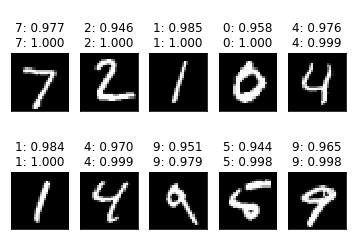

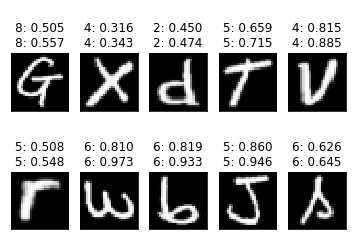

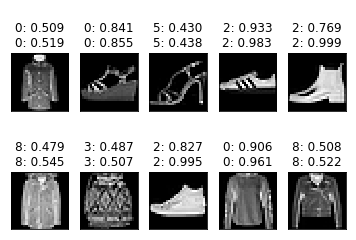

In [14]:
gmm_model.loglam.data = torch.tensor(-8., device=device)

data = enumerate(dl.MNIST_test_loader).__next__()[1][0]
y = gmm_model(data.to(device))
y_base = base_model(data.to(device))

plotting.plot_samples([y, y_base], data)

data = enumerate(dl.EMNIST_test_loader).__next__()[1][0]
y = gmm_model(data.to(device))
y_base = base_model(data.to(device))

plotting.plot_samples([y, y_base], data)

data = enumerate(dl.FMNIST_train_loader).__next__()[1][0]
y = gmm_model(data.to(device))
y_base = base_model(data.to(device))

plotting.plot_samples([y, y_base], data)
